In [2]:

import json
import pickle
from pathlib import Path
from typing import List

import numpy as np
import torch
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, Subset
from torchvision import transforms as tf
from torchvision.datasets import Kitti
from tqdm import tqdm
from xgboost.sklearn import XGBClassifier

from model.densecap import DenseCapModel, densecap_resnet50_fpn

In [3]:
pi_half = np.pi / 2
MAPPING = {0: 'BACK_LEFT', 1: 'BACK_RIGHT', 2: 'FRONT_LEFT', 3: 'FRONT_RIGHT'}
REVERSE_MAPPING = { v: k for k, v in MAPPING.items() }
TRUNCATED_THRESHOLD = 0.05
OCCLUSION_CLASS = 0

def get_alpha_class(alpha: float) -> str:
    if alpha <= 0 and alpha > -pi_half:
        return 'BACK_LEFT'
    elif alpha <= -pi_half and alpha > -np.pi:
        return 'BACK_RIGHT'
    elif alpha <= np.pi and alpha > pi_half:
        return 'FRONT_RIGHT'
    elif alpha <= pi_half and alpha > 0:
        return 'FRONT_LEFT'

In [4]:
def load_model(model_config_path: Path, checkpoint_path: Path, return_features=False, box_per_img=50, verbose=False):
    with open(model_config_path, 'r') as f:
        model_args = json.load(f)

    model = densecap_resnet50_fpn(backbone_pretrained=model_args['backbone_pretrained'],
                                  return_features=return_features,
                                  feat_size=model_args['feat_size'],
                                  hidden_size=model_args['hidden_size'],
                                  max_len=model_args['max_len'],
                                  emb_size=model_args['emb_size'],
                                  rnn_num_layers=model_args['rnn_num_layers'],
                                  vocab_size=model_args['vocab_size'],
                                  fusion_type=model_args['fusion_type'],
                                  box_detections_per_img=box_per_img)

    checkpoint = torch.load(checkpoint_path)
    model.load_state_dict(checkpoint['model'], strict=False)

    if verbose and 'results_on_val' in checkpoint.keys():
        print('[INFO]: checkpoint {} loaded'.format(checkpoint_path))
        print('[INFO]: correspond performance on val set:')
        for k, v in checkpoint['results_on_val'].items():
            if not isinstance(v, dict):
                print('        {}: {:.3f}'.format(k, v))

    return model

params_path = Path("compute_model_params")
model_name = "without_aux"
aux_model_name = "with_aux"
model = load_model(params_path / model_name / "config.json", params_path / (model_name +
 ".pth.tar"), return_features=True)
aux_model = load_model(params_path / aux_model_name / "config.json", params_path / (aux_model_name +
"_end.pth.tar"), return_features=True)

In [8]:
device = torch.device('cuda')


def train_feature_classifier(features: torch.Tensor, classes: List[int]):
    x_train, x_test, y_train, y_test = train_test_split(
        features, classes, train_size=200, test_size=100, random_state=42
    )

    classifier = XGBClassifier(predictor="gpu_predictor", gpu_id=device.index)
    classifier.fit(x_train, y_train)

    accuracy = classifier.score(x_test, y_test)
    print(f"accuracy: {accuracy}")
    predictions = classifier.predict(features)

    return classifier, predictions


def train_classifier(model: DenseCapModel, data_loader: DataLoader):
    model.eval()
    model.to(device)
    model.roi_heads.score_thresh = 0

    object_features = []
    backbone_features = []
    pred_classes = []
    gt_classes = []

    with torch.no_grad():
        # FOR NOW, ASSUME SINGLE ITEM BATCH!
        for images, targets, _ in tqdm(data_loader):
            image = images[0]
            classes = []
            image_boxes = []

            val = image.shape[-2:]
            torch._assert(
                len(val) == 2,
                f"expecting the last two dimensions of the Tensor to be H and W instead got {image.shape[-2:]}",
            )
            original_image_size = (val[0], val[1])

            for target in targets:
                if target['type'][0] != 'Car' or target['truncated'][0] > TRUNCATED_THRESHOLD or target['occluded'][0] != OCCLUSION_CLASS:
                    continue

                alpha_class = get_alpha_class(target['alpha'][0])
                # x_min, y_min, x_max, y_max
                classes.append(alpha_class)

                x_min, y_min, x_max, y_max = target['bbox']
                image_boxes.append(torch.tensor((x_min[0], y_min[0], x_max[0], y_max[0])).to(device))

            if len(image_boxes) < 1:
                continue

            gt_classes.extend([REVERSE_MAPPING[c] for c in classes])

            image_boxes = torch.stack(image_boxes).to(torch.float32).to(device)

            # if images are transformed, I need to scale the boxes..
            # apply model to image                        

            # TODO: extract bounding boxes as single images
            for box in image_boxes:
                box = torch.floor(box).to(int)                
                cut_image = images[:, :, box[1]:box[3], box[0]:box[2]].to(device)
                # print(cut_image.shape)
                cut_image, _ = model.transform(cut_image)
                # print(cut_image.tensors.shape)
                bb_features = model.backbone(cut_image.tensors)                
                # if bb_features['pool'].shape[-1] > 1:
                #     raise Exception
                backbone_features.append(bb_features['pool'].squeeze())

            images, _ = model.transform(images.to(device))
            scale_x, scale_y = (
                images.tensors[0].shape[2] / original_image_size[1],
                images.tensors[0].shape[1] / original_image_size[0],
            )
            image_boxes[:, 0::2] *= scale_x
            image_boxes[:, 1::2] *= scale_y

            features = model.backbone(images.tensors)
            roi_head_results, _ = model.roi_heads(features, [image_boxes], images.image_sizes)

            roi_head_features = []
            for res in roi_head_results:
                roi_head_features.extend(res['feats'])
                if "views" in res:
                    pred_classes.extend(res["views"])
            object_features.extend(roi_head_features)            

    backbone_features = torch.stack(backbone_features)
    backbone_features = backbone_features.flatten(start_dim=1).cpu()

    object_features = torch.stack(object_features)
    object_features = object_features.flatten(start_dim=1).cpu()

    print("training backbone classifier..")
    backbone_classifier, backbone_predictions = train_feature_classifier(backbone_features, gt_classes)
    print("training object classifier..")
    object_classifier, object_predictions = train_feature_classifier(object_features, gt_classes)

    return backbone_classifier, object_classifier, backbone_predictions, object_predictions, gt_classes, pred_classes

In [9]:
transform = tf.Compose([
    # tf.Resize((200, 200)),
    tf.ToTensor(),
])

dataset = Kitti("/home/markus/dev/EgoNet", transform=transform, download=False)
subset = Subset(dataset, np.random.default_rng().choice(np.arange(len(dataset)), 500))
data_loader = DataLoader(subset, batch_size=1, shuffle=False)

print("aux classifier:")
aux_backbone_classifier, aux_object_classifier, aux_backbone_predictions, aux_object_predictions, aux_gt_classes, aux_pred_classes = train_classifier(aux_model, data_loader)
print("normal classifier:")
backbone_classifier, object_classifier, backbone_predictions, object_predictions, gt_classes, _ = train_classifier(model, data_loader)

aux classifier:


100%|██████████| 500/500 [00:51<00:00,  9.75it/s]


training backbone classifier..
accuracy: 0.71
training object classifier..
accuracy: 0.56
normal classifier:


100%|██████████| 500/500 [00:53<00:00,  9.43it/s]


training backbone classifier..
accuracy: 0.76
training object classifier..
accuracy: 0.5


0.6523489932885906
[2, 2, 2, 0, 0, 0, 2, 2, 0, 0, 2, 2, 0, 0, 0, 3, 0, 2, 2, 2, 3, 2, 2, 3, 2, 2, 2, 0, 0, 2, 2, 2, 2, 0, 2, 0, 0, 2, 0, 3, 2, 2, 0, 2, 0, 3, 0, 0, 0, 0, 0, 0, 2, 0, 3, 2, 2, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 1, 2, 2, 0, 0, 0, 2, 3, 0, 2, 0, 0, 0, 2, 2, 2, 0, 3, 0, 0, 3, 3, 0, 0, 0, 0, 0, 0, 2, 0, 3, 2, 2, 3, 3, 2, 0, 0, 0, 2, 1, 0, 2, 0, 0, 2, 0, 0, 0, 1, 2, 2, 0, 0, 2, 0, 0, 0, 0, 2, 0, 3, 2, 2, 2, 2, 2, 2, 0, 2, 2, 0, 0, 0, 0, 2, 2, 2, 2, 0, 0, 0, 2, 3, 2, 2, 2, 0, 0, 2, 2, 2, 2, 2, 0, 2, 0, 2, 0, 2, 2, 0, 0, 0, 2, 2, 2, 2, 0, 3, 2, 2, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 3, 0, 2, 0, 0, 0, 0, 2, 0, 0, 0, 2, 2, 1, 2, 2, 0, 2, 2, 0, 0, 2, 0, 2, 2, 2, 0, 2, 0, 0, 0, 2, 0, 0, 2, 2, 0, 0, 2, 0, 0, 2, 2, 2, 2, 2, 2, 0, 0, 0, 0, 0, 0, 2, 2, 2, 0, 2, 2, 2, 0, 3, 2, 0, 2, 2, 2, 2, 0, 2, 2, 0, 2, 2, 0, 2, 0, 2, 2, 2, 0, 2, 0, 2, 1, 2, 2, 2, 2, 2, 0, 2, 2, 2, 0, 0, 1, 0, 2, 2, 2, 2, 0, 0, 0, 0, 2, 0, 2, 2, 1, 3, 0, 1, 2, 0, 0, 0, 0, 0, 3, 0, 1, 2, 0, 1, 2, 0, 0, 0, 2, 0, 1, 0, 1, 2, 2,

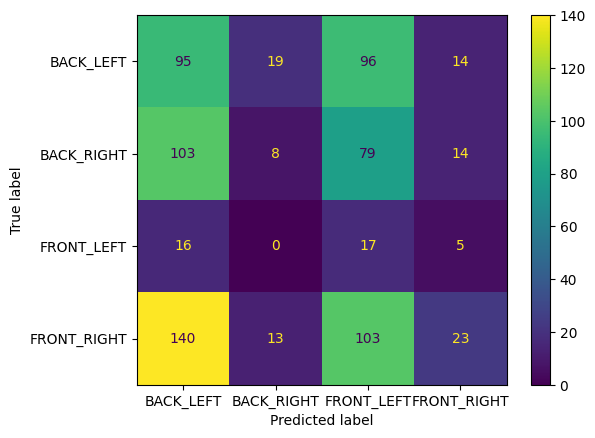

In [10]:
from sklearn.metrics import ConfusionMatrixDisplay

aux_score = (np.array(aux_gt_classes) == aux_object_predictions).sum() / len(aux_gt_classes)
print(aux_score)

print([v.cpu().item() for v in aux_pred_classes])
print(aux_gt_classes)
aux_pred_score = (np.array(aux_gt_classes) == np.array([v.cpu().item() for v in aux_pred_classes])).sum() / len(aux_gt_classes)
print(aux_pred_score)

ConfusionMatrixDisplay.from_predictions(y_true=aux_gt_classes, y_pred=[v.cpu().item() for v in aux_pred_classes], display_labels=[
    v for v in MAPPING.values()
])

0.8308724832214766


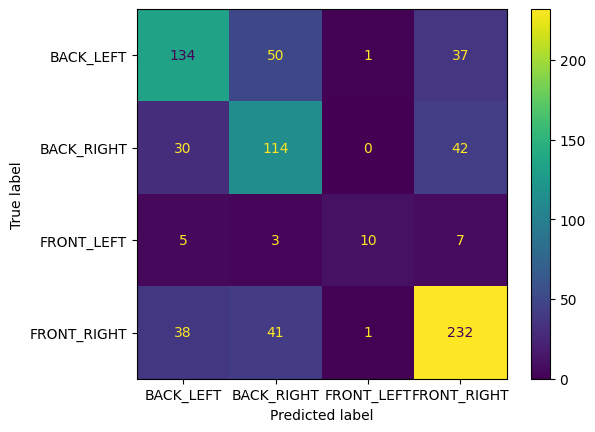

In [8]:
from sklearn.metrics import ConfusionMatrixDisplay
score = (np.array(gt_classes) == backbone_predictions).sum() / len(gt_classes)
print(score)

ConfusionMatrixDisplay.from_predictions(y_true=gt_classes, y_pred=object_predictions, display_labels=[
    v for v in MAPPING.values()
])

In [5]:
import h5py
import os

def save_results_to_file(img_list, all_results, idx_to_token, result_dir):    
    results_dict = {}    
    for img_path, results in zip(img_list, all_results):        

        results_dict[img_path] = []
        for box, cap, score, view in zip(results['boxes'], results['caps'], results['scores'], results['views']):            
            r = {
                'box': [round(c, 2) for c in box.tolist()],
                'score': round(score.item(), 2),
                'cap': ' '.join(idx_to_token[idx] for idx in cap.tolist()
                                if idx_to_token[idx] not in ['<pad>', '<bos>', '<eos>']),
                'view': MAPPING[view.item()]
            }            

            results_dict[img_path].append(r)

    if not os.path.exists(result_dir):
        os.mkdir(result_dir)
    with open(os.path.join(result_dir, 'result.json'), 'w') as f:
        json.dump(results_dict, f, indent=2)    

In [6]:
from pathlib import Path
import pickle

lut_path = Path("./data/VG-regions-dicts-lite.pkl")

with open(lut_path, 'rb') as f:
    look_up_tables = pickle.load(f)

idx_to_token = look_up_tables['idx_to_token']

device = torch.device('cuda')

aux_model.eval()
aux_model.to(device)
all_results = []
img_paths = []

transform = tf.Compose([
    # tf.Resize((200, 200)),
    tf.ToTensor(),
])

dataset = Kitti("/home/markus/dev/EgoNet", transform=transform, download=False)
subset = Subset(dataset, np.random.default_rng().choice(np.arange(len(dataset)), 100))
data_loader = DataLoader(subset, batch_size=1, shuffle=False)

with torch.no_grad():
    for images, targets, paths in tqdm(data_loader):                
        images = images.to(device)
        results = aux_model(images)
        all_results.extend([{k:v.cpu() for k,v in r.items()} for r in results])
        img_paths.extend(paths)


save_results_to_file(img_paths, all_results, idx_to_token, "res")

100%|██████████| 100/100 [00:33<00:00,  3.03it/s]
